In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install transformers
!pip install sentencepiece
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.7 MB/s eta 0:00:00
  Preparing metada

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [6]:
import random
random.seed(42)
galleries = ['animal','tree']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen


In [7]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
    # return ' '.join([w for w in sentence.split() if w != word])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']#['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [8]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [9]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [10]:
from transformers import AutoModel, AutoTokenizer
from umap import UMAP
# umap_model = UMAP(random_state=42)
# umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', random_state=42)
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [11]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          # ctfidf_model=ctfidf_model,
                          top_n_words=1)
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [12]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)
# for i in lst:
#   print(i)

생성된 주제의 수: 99


In [13]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [14]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 84.34it/s]


In [15]:
# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
# hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail, linkage_function=linkage_function)

In [16]:
bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [17]:
# 주제, 분기점 별 클러스터 구성 라벨 수
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]

for j in range(number_of_topics):
  for i in range(len(topics)):
    if topics[i]==j:
      table[j][real_labels[i]]+=1
for j in range(number_of_topics, len(table)):
  row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
  left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
  for i in range(len(table[0])):
    table[j][i] += table[left][i] + table[right][i]
print(len(table))

197


In [18]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
97,196,햄스터,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194,식물,195,햄스터,1.446330
96,195,햄스터,"[0, 1, 10, 12, 15, 18, 21, 22, 23, 24, 25, 27,...",193,나무위키,191,햄스터,1.304870
95,194,식물,"[2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 17, 1...",167,너무,120,이름이,1.275176
94,193,나무위키,"[1, 10, 12, 22, 23, 27, 29, 31, 33, 35, 37, 42...",192,로보쿤,190,나무위키,1.202085
93,192,로보쿤,"[1, 10, 35, 50, 51]",114,로보쿤,102,뚱땡정글,1.176010
...,...,...,...,...,...,...,...,...
4,103,로보쿤,"[1, 35]",35,로보쿤,1,로보쿤,0.774692
3,102,뚱땡정글,"[10, 51]",10,뚱땡정글,51,뚱땡정글,0.732937
2,101,꽃이,"[2, 3, 5]",5,신엽,100,꽃이,0.706776
1,100,꽃이,"[2, 3]",2,식물,3,꽃이,0.623630


In [19]:
df = hierarchical_topics

selected_topics_ids = set()

for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [20]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

In [21]:
!pip install fasttext
import fasttext
from sklearn.cluster import KMeans
import numpy as np
from gensim import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=b1b4de5746a0c60d5520237fe3803f0e3a87509b96a3ce10b91afeb891d38651
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [22]:
model_path = '/content/drive/MyDrive/jolnon/cc.ko.150.bin'

m_fasttext = models.fasttext.load_facebook_model(model_path)

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [25]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

cluster_sums = []

for cluster in clustered_topics:
    total_sum = 0
    for parent_id in cluster:
        row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
        topic_ids = row['Topics']
        cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
        total_sum += cluster_sum
    cluster_sums.append(total_sum)

for idx, cluster_sum in enumerate(cluster_sums):
    print(f"Cluster {idx} contains {cluster_sum} documents.")


Cluster 0 contains 0 documents.
Cluster 1 contains 0 documents.
Cluster 2 contains 600 documents.


In [26]:
embeddings = [m_fasttext.wv[selected_topic_names[i]] for i in range(len(selected_topic_names))]
embed_ids = [selected_topics_ids[i] for i in range(len(selected_topic_names))]

embeddings = np.array(embeddings)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

clustered_topics = [[] for _ in range(n_clusters)]
clustered_topics_name = [[] for _ in range(n_clusters)]
clustered_topics_count = [[] for _ in range(n_clusters)]

for i, label in enumerate(kmeans.labels_):
    clustered_topics[label].append(embed_ids[i])
    clustered_topics_name[label].append(selected_topic_names[i])
    clustered_topics_count[label].append(post_counts[i])

for r in clustered_topics_name:
    print(r)

['표범']
['놔라', '돼지', '냄새', '너무']
['고양이', '나무위키', '식쇼', '떨어지지마라', '케이지', '코코넛', '토마토', '유혈목이', '쥐친구', '뚱땡정글', '귀엽다', '플로리다', '틸레코돈', '이름이', '햄스터', '제라늄', '로보쿤', '거미줄', '프롬프트', '알로카시아', '잠자는쥐']


In [28]:
from sklearn.decomposition import PCA

labels=kmeans.labels_.tolist()
pca = PCA(n_components=2).fit(embeddings)
datapoint = pca.transform(embeddings)

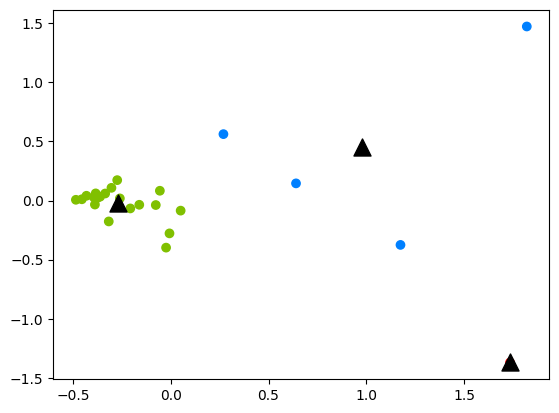

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["#FF0000", "#0080FF", "#80C000", "#800080"]

color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

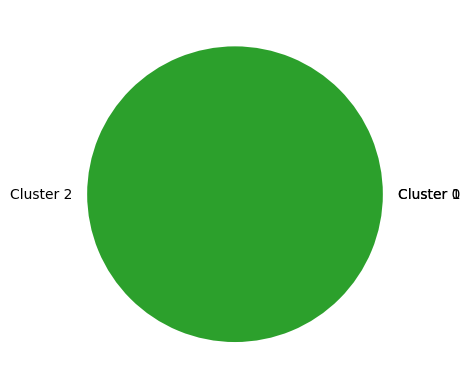

In [30]:
plt.pie(cluster_sums, labels=['Cluster ' + str(i) for i in range(n_clusters)])
plt.show()

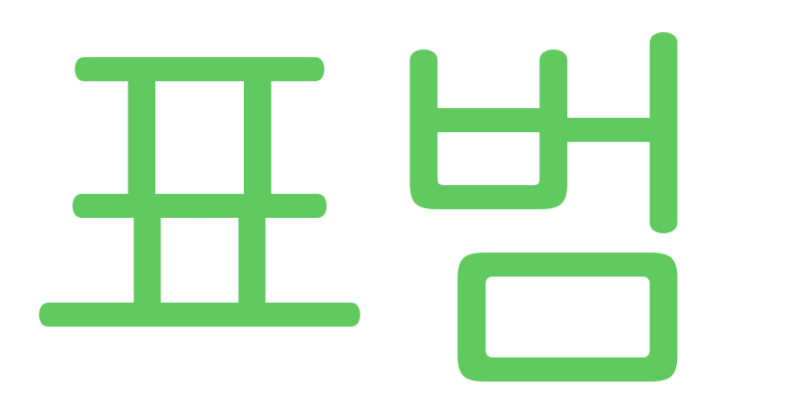

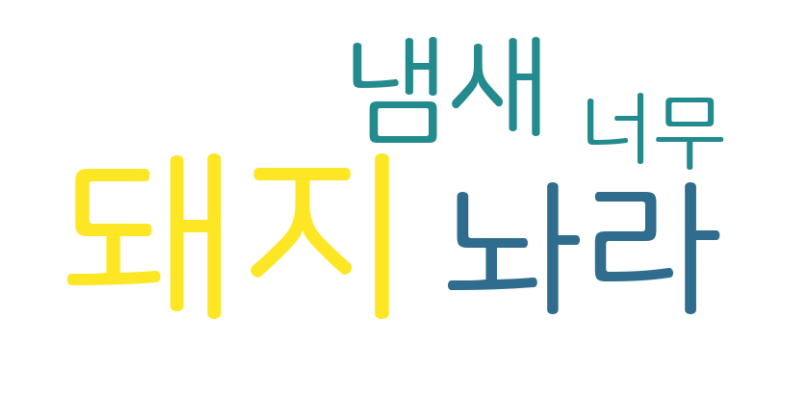

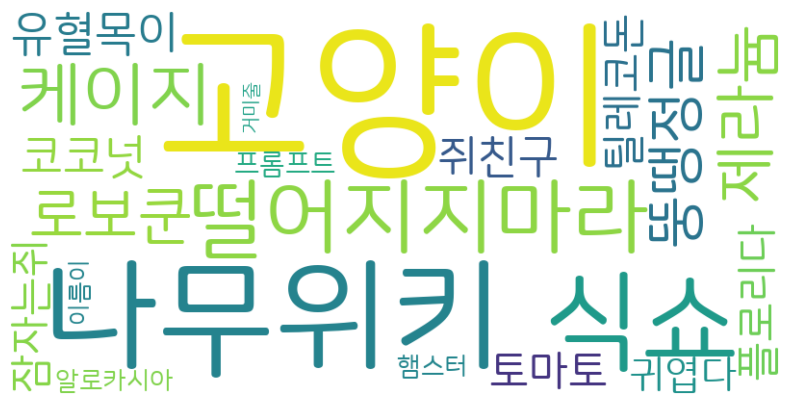

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i in range(n_clusters):
  text = ' '.join(clustered_topics_name[i])

  wordcloud = WordCloud(width=800, height=400, font_path='/content/drive/MyDrive/NanumSquareRoundR.ttf', background_color='white').generate_from_frequencies(dict(zip(clustered_topics_name[i], clustered_topics_count[i])))

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

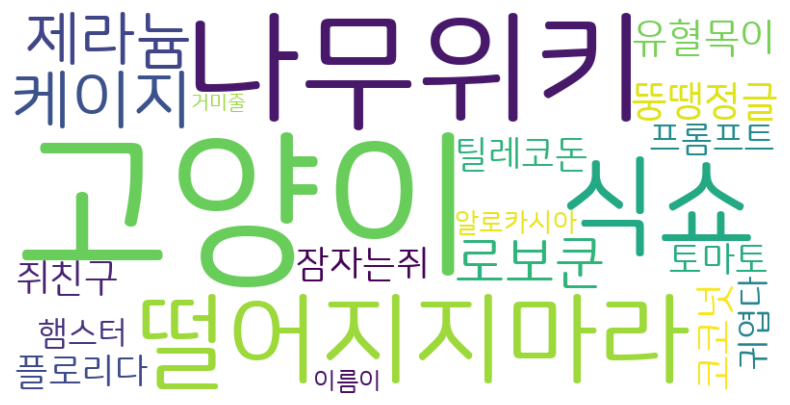

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ''
for i in range(n_clusters):
  text = ' ' + ' '.join(clustered_topics_name[i])

wordcloud = WordCloud(width=800, height=400, font_path='/content/drive/MyDrive/NanumSquareRoundR.ttf', background_color='white').generate_from_frequencies(dict(zip(clustered_topics_name[i], clustered_topics_count[i])))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
# 클러스터 별 라벨 수
clustered_count = [[0, 0], [0, 0], [0, 0]]

for i in range(3):
  for j in clustered_topics[i]:
    clustered_count[i][0] += table[int(j)][0]
    clustered_count[i][1] += table[int(j)][1]

print(clustered_count)
print(sum(x[0] for x in clustered_count), sum(x[1] for x in clustered_count))
print(sum(x[0] for x in clustered_count) + sum(x[1] for x in clustered_count))

[[115, 68], [1900, 6235], [6984, 3752]]
8999 10055
19054


In [34]:
for i in range(3):
  l, r = clustered_count[i][0], clustered_count[i][1]
  #print(f'Cluster #{i+1}: [{l}, {r}] - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
  print(f'Cluster #{i+1}: ({l + r}) - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
  for j in range(len(clustered_topics[i])):
    k = clustered_topics[i][j]
    l, r = table[int(k)][0], table[int(k)][1]
    #print(f'\t- {clustered_topics_name[i][j]}: [{l}, {r}] - [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')
    print(f'\t- {clustered_topics_name[i][j]} ({l + r}): [{100 * l / (l + r):.2F}, {100 * r / (l + r):.2F}]')

Cluster #1: (183) - [62.84, 37.16]
	- 표범 (183): [62.84, 37.16]
Cluster #2: (8135) - [23.36, 76.64]
	- 놔라 (133): [60.90, 39.10]
	- 돼지 (222): [71.17, 28.83]
	- 냄새 (366): [77.05, 22.95]
	- 너무 (7414): [18.60, 81.40]
Cluster #3: (10736) - [65.05, 34.95]
	- 고양이 (600): [82.83, 17.17]
	- 나무위키 (206): [73.30, 26.70]
	- 식쇼 (146): [21.23, 78.77]
	- 떨어지지마라 (346): [12.72, 87.28]
	- 케이지 (267): [88.01, 11.99]
	- 코코넛 (558): [84.77, 15.23]
	- 토마토 (332): [41.57, 58.43]
	- 유혈목이 (202): [77.72, 22.28]
	- 쥐친구 (265): [91.70, 8.30]
	- 뚱땡정글 (334): [91.92, 8.08]
	- 귀엽다 (449): [54.12, 45.88]
	- 플로리다 (258): [29.46, 70.54]
	- 틸레코돈 (153): [47.71, 52.29]
	- 이름이 (783): [16.09, 83.91]
	- 햄스터 (2590): [95.71, 4.29]
	- 제라늄 (150): [38.00, 62.00]
	- 로보쿤 (1587): [57.72, 42.28]
	- 거미줄 (399): [17.04, 82.96]
	- 프롬프트 (225): [57.33, 42.67]
	- 알로카시아 (292): [25.00, 75.00]
	- 잠자는쥐 (594): [78.79, 21.21]
